<a href="https://colab.research.google.com/github/tihunn/emotion_testing/blob/main/emotional_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook with Train emotional tasting

## Import and download database

In [2]:
import numpy as np                                                    # Массивы
import matplotlib.pyplot as plt                                       # Отрисовка графиков
from google.colab import drive                                        # Связь с google диском
import gdown                                                          # Загрузка из google облака
from tensorflow.keras.utils import to_categorical                     # Преобразование категориальных данных в one hot encoding
import os                                                             # Работа с папками и файлами
import shutil
import time                                                           # Утилиты работы со временем
import random                                                         # Работа со случайными числами
import math                                                           # Математические функции
import pickle                                                         # Сохранение и загрузка структур данных Python
import librosa                                                        # Параметризация аудио
from tensorflow.keras.optimizers import Adam, RMSprop                 # Оптимизаторы для обучения моделей
from tensorflow.keras.models import Sequential, Model, load_model     # Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM  # Основные слои
from sklearn.model_selection import train_test_split                  # Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler        # Кодирование категориальных меток, нормирование числовых данных
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Матрица ошибок классификатора
import warnings                                                       # Отключение предупреждений

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Загружаем kaggle.json (вручную загрузите kaggle.json, который вы скачали, через боковое меню "Файлы" в Colab)
!gdown 1Y5WI645-iPqOS55g4wNKsHaWRAWmCQfi
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Устанавливаем kaggle API, если ещё не установлен
!pip install -q kaggle

# Скачиваем набор данных в текущую директорию
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess -p /content/
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee -p /content/
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio -p /content/

# Разархивируем данные, если они находятся в zip формате
!unzip -q /content/toronto-emotional-speech-set-tess.zip
!unzip -q /content/surrey-audiovisual-expressed-emotion-savee.zip
!mkdir -p /content/ravdess/
!unzip -q /content/ravdess-emotional-speech-audio.zip -d /content/ravdess/
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)
# Удаляем zip-архивы, если они больше не нужны
!rm -r /content/toronto-emotional-speech-set-tess.zip /content/sample_data \
"/content/tess toronto emotional speech set data" kaggle.json \
/content/surrey-audiovisual-expressed-emotion-savee.zip \
/content/ravdess/ravdess-emotional-speech-audio.zip


Downloading...
From: https://drive.google.com/uc?id=1Y5WI645-iPqOS55g4wNKsHaWRAWmCQfi
To: /content/kaggle.json
100% 67.0/67.0 [00:00<00:00, 194kB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 426M/428M [00:01<00:00, 254MB/s]
100% 428M/428M [00:01<00:00, 240MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
 92% 99.0M/107M [00:00<00:00, 195MB/s]
100% 107M/107M [00:00<00:00, 198MB/s] 
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 98% 421M/429M [00:02<00:00, 236MB/s]
100% 429M/429M [00:02<00:00, 209MB/s]


100%|██████████| 429M/429M [00:07<00:00, 63.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1
rm: cannot remove '/content/ravdess/ravdess-emotional-speech-audio.zip': No such file or directory


## упорядочивание папок

In [3]:
def count_files_in_directory(path, depth=0):
    # Получаем содержимое директории
    try:
        entries = os.listdir(path)
    except FileNotFoundError:
        print("Указанная папка не найдена.")
        return

    # Списки для файлов и поддиректорий
    files = []
    directories = []

    # Разделение файлов и папок в текущей директории
    for entry in entries:
        full_path = os.path.join(path, entry)
        if os.path.isfile(full_path):
            files.append(full_path)
        elif os.path.isdir(full_path):
            directories.append(full_path)

    # Подсчет и вывод форматов файлов
    if files:
        formats = {os.path.splitext(file)[1][1:].lower() for file in files}
        indent = ' ' * (2 * depth)
        print(f"{indent}Папка '{os.path.basename(path)}': {len(files)} файлов, форматы: {', '.join(formats)}")
    else:
        print(f"{' ' * (2 * depth)}Папка '{os.path.basename(path)}' пуста.")

    # Рекурсивно обходим поддиректории с увеличением отступа
    for directory in directories:
        count_files_in_directory(directory, depth + 1)


count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'OAF_neutral': 200 файлов, форматы: wav
  Папка 'YAF_sad': 200 файлов, форматы: wav
  Папка 'YAF_neutral': 200 файлов, форматы: wav
  Папка 'OAF_disgust': 200 файлов, форматы: wav
  Папка 'OAF_Pleasant_surprise': 200 файлов, форматы: wav
  Папка 'OAF_Fear': 200 файлов, форматы: wav
  Папка 'YAF_fear': 200 файлов, форматы: wav
  Папка 'YAF_disgust': 200 файлов, форматы: wav
  Папка 'YAF_angry': 200 файлов, форматы: wav
  Папка 'YAF_pleasant_surprised': 200 файлов, форматы: wav
  Папка 'YAF_happy': 200 файлов, форматы: wav
  Папка 'OAF_happy': 200 файлов, форматы: wav
  Папка 'OAF_angry': 200 файлов, форматы: wav
  Папка 'OAF_Sad': 200 файлов, форматы: wav


In [4]:
def reorganize_folders(base_path):
    # Список для хранения названий созданных папок
    created_folders = []

    # Получаем список всех папок в указанной директории
    for folder_name in os.listdir(base_path):
        # Полный путь к текущей папке
        folder_path = os.path.join(base_path, folder_name)

        # Проверяем, является ли элемент папкой и имеет ли разделитель '_'
        if os.path.isdir(folder_path) and '_' in folder_name:
            # Получаем "последнее слово" после разделителя '_'
            target_folder_name = folder_name.split('_')[-1].lower()
            target_folder_path = os.path.join(base_path, target_folder_name)

            # Обработка специального случая
            if folder_name == 'YAF_pleasant_surprised':
                target_folder_name = 'surprise'
                target_folder_path = os.path.join(base_path, target_folder_name)

            # Создаем папку назначения, если она не существует
            if target_folder_name not in created_folders:
                os.makedirs(target_folder_path, exist_ok=True)
                created_folders.append(target_folder_name)

            # Перемещаем все файлы из текущей папки в папку назначения
            for file_name in os.listdir(folder_path):
                source_file_path = os.path.join(folder_path, file_name)

                # Проверяем, что это файл, а не вложенная папка
                if os.path.isfile(source_file_path):
                    shutil.move(source_file_path, target_folder_path)

            # Удаляем пустую исходную папку
            os.rmdir(folder_path)

    # Возвращаем список созданных папок
    return created_folders

# Пример вызова функции
created_folders = reorganize_folders("/content/TESS Toronto emotional speech set data")
print("Созданные папки:", created_folders)


Созданные папки: ['neutral', 'sad', 'disgust', 'surprise', 'fear', 'angry', 'happy']


In [5]:
count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'sad': 400 файлов, форматы: wav
  Папка 'happy': 400 файлов, форматы: wav
  Папка 'neutral': 400 файлов, форматы: wav
  Папка 'disgust': 400 файлов, форматы: wav
  Папка 'surprise': 400 файлов, форматы: wav
  Папка 'fear': 400 файлов, форматы: wav
  Папка 'angry': 400 файлов, форматы: wav


In [6]:
import os
import shutil

def distribute_ravdess_files(source_folder, target_folder):
    # Соответствие номеров классов и их названий
    class_map = {
        '01': 'neutral',
        '02': 'neutral',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fear',
        '07': 'disgust',
        '08': 'surprise'
    }

    # Создаем целевые папки для каждого класса, если они еще не созданы
    for class_name in class_map.values():
        os.makedirs(os.path.join(target_folder, class_name), exist_ok=True)

    # Рекурсивно проходим по всем файлам и подкаталогам в исходной папке
    for root, _, files in os.walk(source_folder):
        for file_name in files:
            # Проверяем, является ли файл аудиофайлом в нужном формате
            if file_name.endswith('.wav'):
                # Извлекаем класс из названия файла
                class_number = file_name.split('-')[2]

                # Если класс присутствует в class_map, перемещаем файл
                if class_number in class_map:
                    class_name = class_map[class_number]
                    target_class_folder = os.path.join(target_folder, class_name)

                    # Полные пути к исходному и целевому файлам
                    source_file_path = os.path.join(root, file_name)
                    target_file_path = os.path.join(target_class_folder, file_name)

                    # Перемещаем файл в соответствующую папку
                    shutil.move(source_file_path, target_file_path)
                    print(f"Файл {file_name} перемещен в {target_class_folder}")



distribute_ravdess_files('/content/ravdess', '/content/TESS Toronto emotional speech set data')


Файл 03-01-05-02-02-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/angry
Файл 03-01-02-02-02-01-09.wav перемещен в /content/TESS Toronto emotional speech set data/neutral
Файл 03-01-08-02-01-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/surprise
Файл 03-01-06-02-01-01-09.wav перемещен в /content/TESS Toronto emotional speech set data/fear
Файл 03-01-07-01-01-01-09.wav перемещен в /content/TESS Toronto emotional speech set data/disgust
Файл 03-01-04-01-02-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/sad
Файл 03-01-07-01-01-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/disgust
Файл 03-01-08-02-02-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/surprise
Файл 03-01-04-02-01-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/sad
Файл 03-01-07-02-02-02-09.wav перемещен в /content/TESS Toronto emotional speech set data/disgust
Файл 03-01-03-02-02-01-09.wav п

In [7]:
count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'sad': 592 файлов, форматы: wav
  Папка 'happy': 592 файлов, форматы: wav
  Папка 'neutral': 688 файлов, форматы: wav
  Папка 'disgust': 592 файлов, форматы: wav
  Папка 'surprise': 592 файлов, форматы: wav
  Папка 'fear': 592 файлов, форматы: wav
  Папка 'angry': 592 файлов, форматы: wav


In [8]:
import os
import shutil

def organize_audio_files(source_folder, dataset_folder='data'):
    # Название папок и соответствие сокращений классов
    class_map = {
        'n': 'neutral',
        'd': 'disgust',
        'sa': 'sad',
        'h': 'happy',
        'su': 'surprise',
        'a': 'angry',
        'f': 'fear'
    }

    # Создаем основную папку набора данных и подкатегории
    os.makedirs(dataset_folder, exist_ok=True)
    for class_name in class_map.values():
        os.makedirs(os.path.join(dataset_folder, class_name), exist_ok=True)

    # Перебираем все файлы в исходной папке
    for file_name in os.listdir(source_folder):
        # Проверяем, что это файл и он имеет формат .wav
        file_path = os.path.join(source_folder, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.wav'):
            # Извлекаем часть после символа "_"
            parts = file_name.split('_')
            if len(parts) < 2:
                continue  # Пропускаем файл, если он не соответствует формату

            # Класс - часть после "_"
            class_code = parts[1][0:2]  # Пробуем извлечь первые две буквы после "_"

            # Проверяем, есть ли такой класс в class_map, иначе проверяем первую букву
            if class_code not in class_map:
                class_code = class_code[0]  # Сокращаем до одной буквы, если двухбуквенный код не найден

            # Если класс найден в class_map, перемещаем файл в нужную папку
            if class_code in class_map:
                target_folder = os.path.join(dataset_folder, class_map[class_code])
                shutil.move(file_path, os.path.join(target_folder, file_name))
                # print(f"Файл {file_name} перемещен в {target_folder}")
            else:
                print(f"Класс не распознан для файла {file_name}")

# Пример вызова функции
organize_audio_files('/content/ALL', "/content/SAVEE")


In [9]:
count_files_in_directory("/content/SAVEE")

Папка 'SAVEE' пуста.
  Папка 'sad': 60 файлов, форматы: wav
  Папка 'happy': 60 файлов, форматы: wav
  Папка 'neutral': 120 файлов, форматы: wav
  Папка 'disgust': 60 файлов, форматы: wav
  Папка 'surprise': 60 файлов, форматы: wav
  Папка 'fear': 60 файлов, форматы: wav
  Папка 'angry': 60 файлов, форматы: wav


In [ ]:
# prompt: write code for remove half data in /content/SAVEE/neutral

import os
import random

def remove_half_data(directory, num_need):
    """Removes half of the files in a directory at random."""
    try:
        files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        num_files_to_remove = len(files) - num_need
        files_to_remove = random.sample(files, num_files_to_remove)

        for file in files_to_remove:
            file_path = os.path.join(directory, file)
            os.remove(file_path)
            print(f"Removed: {file_path}")
        print(f"Removed {num_files_to_remove} files from {directory}")
    except FileNotFoundError:
        print(f"Error: Directory '{directory}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
remove_half_data('/content/SAVEE/neutral', 60)

In [ ]:
remove_half_data("/content/TESS Toronto emotional speech set data/neutral", 592)

In [17]:
count_files_in_directory("/content/SAVEE")
count_files_in_directory("/content/TESS Toronto emotional speech set data")

Папка 'SAVEE' пуста.
  Папка 'sad': 60 файлов, форматы: wav
  Папка 'happy': 60 файлов, форматы: wav
  Папка 'neutral': 60 файлов, форматы: wav
  Папка 'disgust': 60 файлов, форматы: wav
  Папка 'surprise': 60 файлов, форматы: wav
  Папка 'fear': 60 файлов, форматы: wav
  Папка 'angry': 60 файлов, форматы: wav
Папка 'TESS Toronto emotional speech set data' пуста.
  Папка 'sad': 592 файлов, форматы: wav
  Папка 'happy': 592 файлов, форматы: wav
  Папка 'neutral': 592 файлов, форматы: wav
  Папка 'disgust': 592 файлов, форматы: wav
  Папка 'surprise': 592 файлов, форматы: wav
  Папка 'fear': 592 файлов, форматы: wav
  Папка 'angry': 592 файлов, форматы: wav


## Определение оптимальной продолжительности

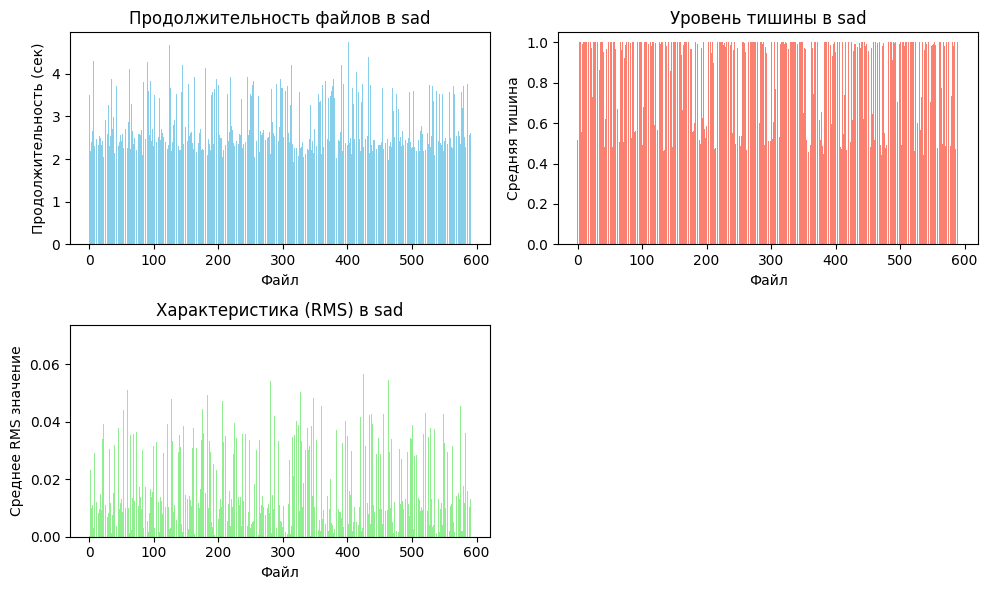

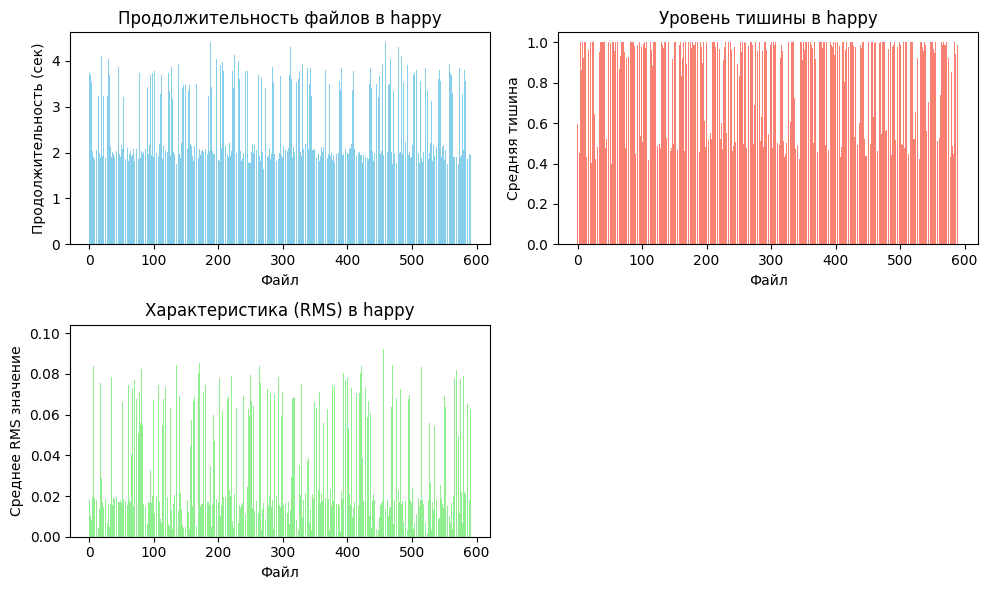

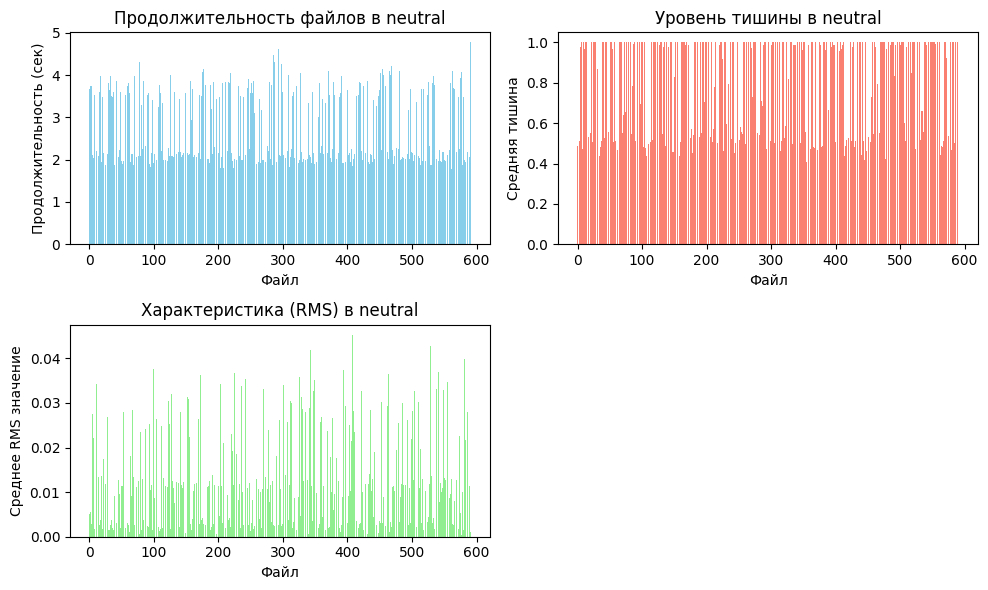

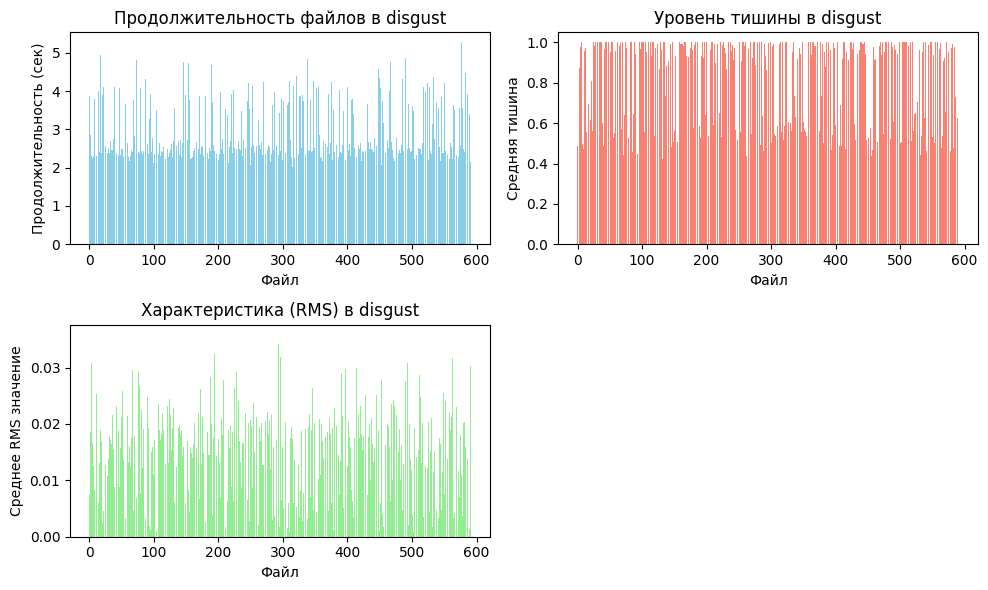

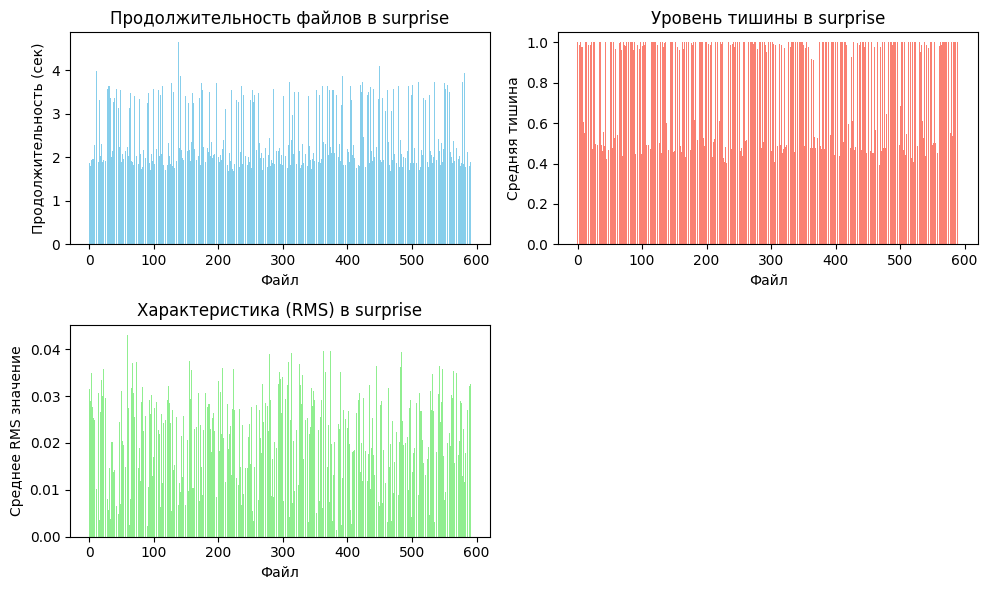

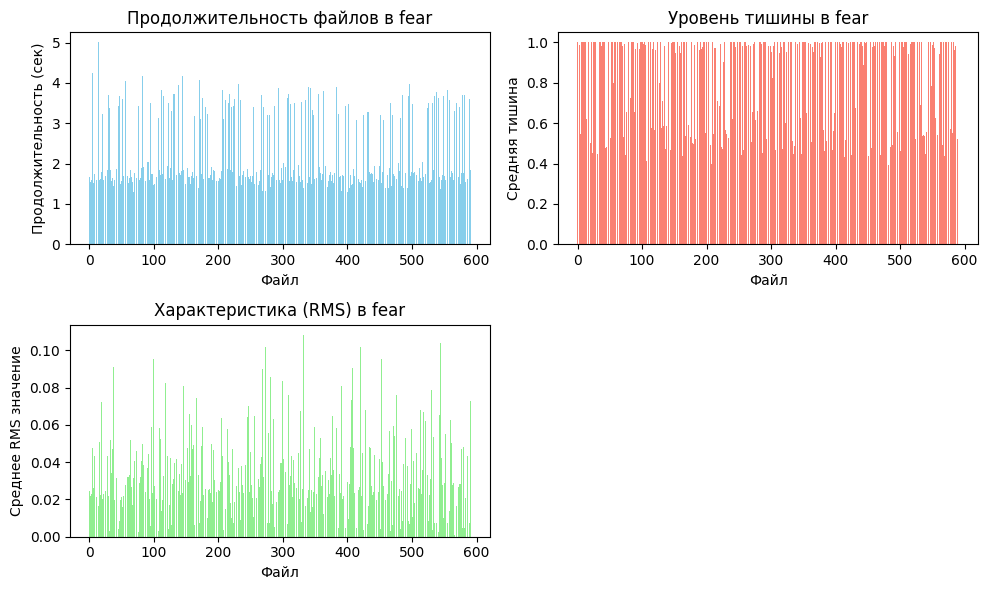

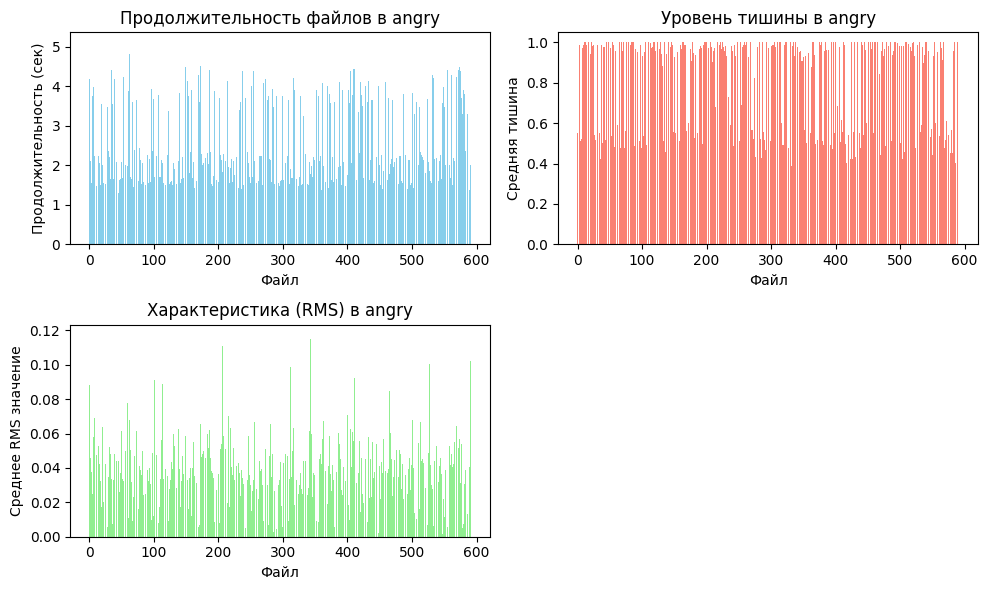

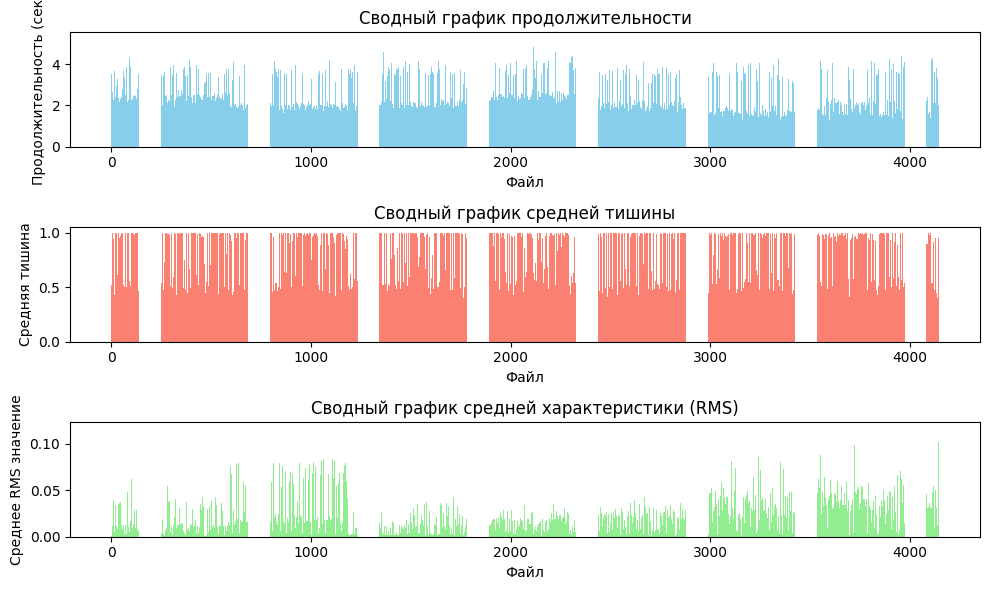

In [22]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

def analyze_audio_files(base_path):
    stats = {}

    # Проход по каждой папке в базе данных
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if os.path.isdir(folder_path):
            # Инициализируем вложенный словарь для папки
            stats[folder_name] = {
                "duration": [],
                "silence": [],
                "some_feature": []  # Пример: можно добавить более специфическую характеристику
            }

            # Проход по каждому файлу в папке
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                if os.path.isfile(file_path) and file_path.endswith('.wav'):
                    # Загружаем аудиофайл
                    y, sr = librosa.load(file_path)

                    # Анализ продолжительности
                    duration = librosa.get_duration(y=y, sr=sr)
                    stats[folder_name]["duration"].append(duration)

                    # Анализ тишины: ищем сегменты ниже порога амплитуды (например, -40 дБ)
                    silence_threshold = 0.01
                    silence_frames = librosa.effects.split(y, top_db=40)
                    silence_feature = np.zeros(len(y), dtype=int)
                    for start, end in silence_frames:
                        silence_feature[start:end] = 1
                    stats[folder_name]["silence"].append(silence_feature)

                    # Добавление другой характеристики (пример: RMS энергии)
                    rms = librosa.feature.rms(y=y)[0]
                    stats[folder_name]["some_feature"].append(rms)

    return stats

def plot_statistics(stats):
    for folder_name, data in stats.items():
        # Показ данных по продолжительности и тишине
        plt.figure(figsize=(10, 6))

        # График продолжительности
        plt.subplot(2, 2, 1)
        plt.bar(range(len(data["duration"])), data["duration"], color='skyblue')
        plt.title(f"Продолжительность файлов в {folder_name}")
        plt.xlabel("Файл")
        plt.ylabel("Продолжительность (сек)")

        # График тишины
        plt.subplot(2, 2, 2)
        silence_averages = [np.mean(s) for s in data["silence"]]
        plt.bar(range(len(silence_averages)), silence_averages, color='salmon')
        plt.title(f"Уровень тишины в {folder_name}")
        plt.xlabel("Файл")
        plt.ylabel("Средняя тишина")

        # График характеристики (например, RMS энергии)
        plt.subplot(2, 2, 3)
        avg_feature = [np.mean(f) for f in data["some_feature"]]
        plt.bar(range(len(avg_feature)), avg_feature, color='lightgreen')
        plt.title(f"Характеристика (RMS) в {folder_name}")
        plt.xlabel("Файл")
        plt.ylabel("Среднее RMS значение")

        plt.tight_layout()
        plt.show()

    # Сводный график для всех файлов всех папок
    all_durations = [dur for folder_data in stats.values() for dur in folder_data["duration"]]
    all_silences = [np.mean(s) for folder_data in stats.values() for s in folder_data["silence"]]
    all_features = [np.mean(f) for folder_data in stats.values() for f in folder_data["some_feature"]]

    plt.figure(figsize=(10, 6))

    # График всех продолжительностей
    plt.subplot(3, 1, 1)
    plt.bar(range(len(all_durations)), all_durations, color='skyblue')
    plt.title("Сводный график продолжительности")
    plt.xlabel("Файл")
    plt.ylabel("Продолжительность (сек)")

    # График всех средних уровней тишины
    plt.subplot(3, 1, 2)
    plt.bar(range(len(all_silences)), all_silences, color='salmon')
    plt.title("Сводный график средней тишины")
    plt.xlabel("Файл")
    plt.ylabel("Средняя тишина")

    # График всех характеристик (RMS энергии)
    plt.subplot(3, 1, 3)
    plt.bar(range(len(all_features)), all_features, color='lightgreen')
    plt.title("Сводный график средней характеристики (RMS)")
    plt.xlabel("Файл")
    plt.ylabel("Среднее RMS значение")

    plt.tight_layout()
    plt.show()

# Пример вызова функций
base_path = "/content/TESS Toronto emotional speech set data"
stats = analyze_audio_files(base_path)
plot_statistics(stats)


## стандартизация продолжительности

In [19]:
import os
import librosa
import soundfile as sf
import numpy as np

def normalise_duration(input_file_path, output_folder_path, target_duration=2.0):
    # Загружаем аудиофайл
    y, sr = librosa.load(input_file_path)

    # Определяем текущую продолжительность файла
    current_duration = librosa.get_duration(y=y, sr=sr)

    # Проверяем, нужно ли растягивать или обрезать
    if current_duration >= target_duration:
        # Если файл длиннее 2 секунд, обрезаем его
        y_processed = y[:int(target_duration * sr)]
        print(f"Файл '{os.path.basename(input_file_path)}' обрезан до 2 секунд.")
    else:
        # Если файл короче 2 секунд, вычисляем недостающую длину и повторяем его
        repeats = int(np.ceil(target_duration / current_duration))  # Количество повторений
        y_stretched = np.tile(y, repeats)  # Повторение сигнала

        # Обрезаем до точно 2 секунд
        y_processed = y_stretched[:int(target_duration * sr)]
        print(f"Файл '{os.path.basename(input_file_path)}' удлинен до 2 секунд.")

    # Генерируем путь для сохранения нового файла
    output_file_path = os.path.join(output_folder_path, os.path.basename(input_file_path))

    # Сохраняем обработанный файл
    sf.write(output_file_path, y_processed, sr)
    print(f"Файл '{os.path.basename(input_file_path)}' сохранен в '{output_file_path}'.")

normalise_duration("/content/TESS Toronto emotional speech set data/fear/OAF_back_fear.wav", \
                           "/content/", target_duration=2)

Файл 'OAF_back_fear.wav' удлинен до 2 секунд.
Файл 'OAF_back_fear.wav' сохранен в '/content/OAF_back_fear.wav'.


In [20]:
def create_norm_duration_dataset(input_folder_path, output_folder_path):
    # Убедимся, что корневая папка для сохранения нового набора данных существует
    os.makedirs(output_folder_path, exist_ok=True)

    # Рекурсивный обход папок и файлов в исходной директории
    for root, dirs, files in os.walk(input_folder_path):
        # Создаем эквивалентную директорию в папке назначения
        relative_path = os.path.relpath(root, input_folder_path)
        output_dir = os.path.join(output_folder_path, relative_path)
        os.makedirs(output_dir, exist_ok=True)

        # Проходим по каждому файлу в текущей директории
        for file_name in files:
            # Проверяем, что это аудиофайл формата .wav
            if file_name.endswith('.wav'):
                input_file_path = os.path.join(root, file_name)

                # Применяем функцию stretch_audio_to_2_seconds для обработки файла
                normalise_duration(input_file_path, output_dir)
                print(f"Файл '{file_name}' обработан и сохранен в '{output_dir}'.")


create_norm_duration_dataset("TESS Toronto emotional speech set data", "TESS2")
create_norm_duration_dataset("SAVEE", "SAVEE2")

Streaming output truncated to the last 5000 lines.
Файл 'OAF_germ_ps.wav' сохранен в 'TESS2/surprise/OAF_germ_ps.wav'.
Файл 'OAF_germ_ps.wav' обработан и сохранен в 'TESS2/surprise'.
Файл 'OAF_dodge_ps.wav' обрезан до 2 секунд.
Файл 'OAF_dodge_ps.wav' сохранен в 'TESS2/surprise/OAF_dodge_ps.wav'.
Файл 'OAF_dodge_ps.wav' обработан и сохранен в 'TESS2/surprise'.
Файл 'OAF_shirt_ps.wav' удлинен до 2 секунд.
Файл 'OAF_shirt_ps.wav' сохранен в 'TESS2/surprise/OAF_shirt_ps.wav'.
Файл 'OAF_shirt_ps.wav' обработан и сохранен в 'TESS2/surprise'.
Файл 'YAF_bone_ps.wav' удлинен до 2 секунд.
Файл 'YAF_bone_ps.wav' сохранен в 'TESS2/surprise/YAF_bone_ps.wav'.
Файл 'YAF_bone_ps.wav' обработан и сохранен в 'TESS2/surprise'.
Файл 'YAF_vote_ps.wav' обрезан до 2 секунд.
Файл 'YAF_vote_ps.wav' сохранен в 'TESS2/surprise/YAF_vote_ps.wav'.
Файл 'YAF_vote_ps.wav' обработан и сохранен в 'TESS2/surprise'.
Файл '03-01-08-01-01-02-13.wav' обрезан до 2 секунд.
Файл '03-01-08-01-01-02-13.wav' сохранен в 'TESS2/su

## Создание обучающего набора

In [21]:
# Установка констант
FILE_DIR = "/content/"                    # Папка с файлами датасета
CLASS_LIST = created_folders              # Список классов, порядок меток не определен!
                                          # порядок словаря сохраняется, я спрашивал у gpt, это с 3.7 версии пайтона, иначе нужно было бы юзать отдельную встроеную функцию
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 400                         # Общее количество файлов в каждом классе (вручную len писал было 400)
FILE_INDEX_TRAIN_SPLIT = 400              # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.15                   # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала (звуки очень короткие ниже написал функцию для опеределения самой короткой)
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

# Функция параметризации аудио
def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)     # Хромаграмма
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)                   # Мел-кепстральные коэффициенты
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)                                        # Среднеквадратическая амплитуда
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length) # Спектральный центроид
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)  # Ширина полосы частот
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)    # Спектральный спад частоты
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)                            # Пересечения нуля

    # Сборка признаков в общий список:
    features = {'rmse': rmse,
                'spct': spec_cent,
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

# Функция формирования набора признаков и метки класса для аудиофайла
def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec) # Загрузка в 'y' первых duration_sec секунд аудиосигнала
    feat = get_features(y, sr)                                        # Извлечение параметров из аудиосигнала

    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v
    feature_set = features.T                                          # формирования набора признаков

    y_label = to_categorical(class_index, CLASS_COUNT)                # Перевод номера класса в one hot encoding

    return feature_set, y_label

# Функция формирования подвыборки признаков и меток класса для одного файла
def create_train_data(database_path, # path for data base
                 duration_sec=1,  # длительность аудио в секундах
                 ):
    curr_time = time.time() # Фиксация времени старта формирования выборки
    # class_name = CLASS_LIST[class_index]
    x_data = None # Списки для последовательностей входных данных и меток класса
    y_data = None

    # Проходим по всем папкам в указанной директории
    for folder_of_class in os.listdir(database_path):
        # Полный путь к текущей папке
        folder_path_of_class = os.path.join(database_path, folder_of_class)

        # Проверяем, что это папка
        if os.path.isdir(folder_path_of_class):
            # Проверяем, есть ли папка в списке created_folders и получаем её индекс
            if folder_of_class in created_folders:
                class_index = created_folders.index(folder_of_class)

                # Перебираем файлы в текущей папке
                for file_name in os.listdir(folder_path_of_class):
                    x_list = [] # список для составления всех фич к одному файлу
                    y_list = [] # hoe этого класса
                    file_path = os.path.join(folder_path_of_class, file_name)
                    feature_set, y_label = get_feature_list_from_file(class_index, file_path, duration_sec) # Выборка признаков и метки класса для произведения
                    for j in range(feature_set.shape[0]): # Добавление данных в наборы
                        x_list.append(feature_set[j])
                        y_list.append(y_label)
                    x_data = x_list if x_data is None else np.vstack([x_data, x_list])
                    y_data = y_list if y_data is None else np.vstack([y_data, y_list])

                print(f'Эмоция {CLASS_LIST[class_index]} готова -> {round(time.time() - curr_time)} c')  # Вывод информации о готовности обработки датасета
                curr_time = time.time()
            else:
                print(f"Папка '{folder_of_class}' не найдена в списке created_folders.")  # ну тип обработка ошибки на всякий

    return x_data, y_data

# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = create_train_data("/content/TESS2", duration_sec=2)
x_val_data, y_val_data = create_train_data("/content/SAVEE2", duration_sec=2)

Эмоция sad готова -> 106 c
Эмоция happy готова -> 114 c
Эмоция neutral готова -> 103 c
Эмоция disgust готова -> 107 c
Эмоция surprise готова -> 124 c
Эмоция fear готова -> 150 c
Эмоция angry готова -> 154 c
Эмоция sad готова -> 9 c
Эмоция happy готова -> 9 c
Эмоция neutral готова -> 10 c
Эмоция disgust готова -> 10 c
Эмоция surprise готова -> 9 c
Эмоция fear готова -> 10 c
Эмоция angry готова -> 10 c


## Сохранение и загрузка наборов

In [24]:
# prompt: сохрани на гугл диск x_train_data, y_train_data, x_val_data, y_val_data

import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path where you want to save the data on Google Drive
save_path = '/content/drive/MyDrive/audio_emotion_recognition_data'  # Change to your desired location

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)


# Save the NumPy arrays to files in the specified directory
np.save(os.path.join(save_path, 'x_train_data.npy'), x_train_data)
np.save(os.path.join(save_path, 'y_train_data.npy'), y_train_data)
np.save(os.path.join(save_path, 'x_val_data.npy'), x_val_data)
np.save(os.path.join(save_path, 'y_val_data.npy'), y_val_data)

print("Data saved to Google Drive:", save_path)

Mounted at /content/drive
Data saved to Google Drive: /content/drive/MyDrive/audio_emotion_recognition_data


In [1]:
# prompt: напиши код для чтения вышесозданых файлов в переменные

import numpy as np
import os

# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define the path where the data is saved on Google Drive
save_path = '/content/drive/MyDrive/audio_emotion_recognition_data'

# Load the NumPy arrays from the files
try:
  x_train_data = np.load(os.path.join(save_path, 'x_train_data.npy'))
  y_train_data = np.load(os.path.join(save_path, 'y_train_data.npy'))
  x_val_data = np.load(os.path.join(save_path, 'x_val_data.npy'))
  y_val_data = np.load(os.path.join(save_path, 'y_val_data.npy'))

  print("Data loaded successfully from Google Drive.")

except FileNotFoundError:
  print(f"Error: Data files not found at {save_path}.")
except Exception as e:
  print(f"An error occurred while loading data: {e}")

Mounted at /content/drive
Data loaded successfully from Google Drive.


## создание выборок

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Shuffle the combined data and labels in unison
indices = np.random.permutation(len(x_train_data))
x_shuffled_train = x_train_data[indices]
y_shuffled_train = y_train_data[indices]

indices = np.random.permutation(len(x_val_data))
x_shuffled_val = x_val_data[indices]
y_shuffled_val = y_val_data[indices]

# Normalize the combined data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_shuffled_train)
x_val = scaler.fit_transform(x_shuffled_val)

y_train = y_shuffled_train
y_val = y_shuffled_val

## архитектура модели

In [4]:
# Функция компиляции и обучения модели с одними и теми же параметрами

def compile_train(model,         # модель нейронной сети
                  epochs=50,    # количество эпох обучения
                  batch_size=20  # размер батча
                  ):
    # Компиляция
    model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика обучения
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

    return history

# Функция оценки точности модели на заданной выборке
def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

In [7]:
# prompt: напиши простую архитектуру для запоминания врееных рядов и распознавания 7 классов

from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ... (your existing code)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

def create_model(input_shape, num_classes):
    model = keras.Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Example usage (assuming you have x_train, y_train, etc. defined)
input_shape = (x_train.shape[1], 1)  # Adjust input_shape as needed
num_classes = 7  # Number of classes

model = create_model(input_shape, num_classes)
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), \
          callbacks=[early_stopping, model_checkpoint]) # Adjust epochs and batch size

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 37, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,583 (471.03 KB)

 Trainable params: 120,583 (471.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 93s 8ms/step - accuracy: 0.4393 - loss: 1.4320 - val_accuracy: 0.1707 - val_loss: 2.8261
Epoch 2/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.6407 - loss: 0.9546 - val_accuracy: 0.1731 - val_loss: 2.9482
Epoch 3/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 134s 8ms/step - accuracy: 0.6891 - loss: 0.8223 - val_accuracy: 0.1636 - val_loss: 3.1929
Epoch 4/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 145s 8ms/step - accuracy: 0.7209 - loss: 0.7402 - val_accuracy: 0.1667 - val_loss: 3.1891
Epoch 5/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 140s 8ms/step - accuracy: 0.7430 - loss: 0.6821 - val_accuracy: 0.1735 - val_loss: 3.4899
Epoch 6/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 91s 8ms/step - accuracy: 0.7643 - loss: 0.6260 - val_accuracy: 0.1733 - val_loss: 3.7609


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 1, 37)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 1, 128)         │         84,992 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 1, 128)         │              0 │ lstm_6[0][0],          │
│                           │                        │                │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 7)              │            455 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 93,703 (366.03 KB)

 Trainable params: 93,703 (366.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.4702 - loss: 1.4131 - val_accuracy: 0.1921 - val_loss: 2.6054
Epoch 2/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.6517 - loss: 0.9368 - val_accuracy: 0.1883 - val_loss: 2.7816
Epoch 3/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.6872 - loss: 0.8402 - val_accuracy: 0.1827 - val_loss: 2.9391
Epoch 4/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.7059 - loss: 0.7876 - val_accuracy: 0.1776 - val_loss: 3.0737
Epoch 5/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.7165 - loss: 0.7570 - val_accuracy: 0.1819 - val_loss: 3.1507
Epoch 6/30
11267/11267 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.7257 - loss: 0.7312 - val_accuracy: 0.1757 - val_loss: 3.2853


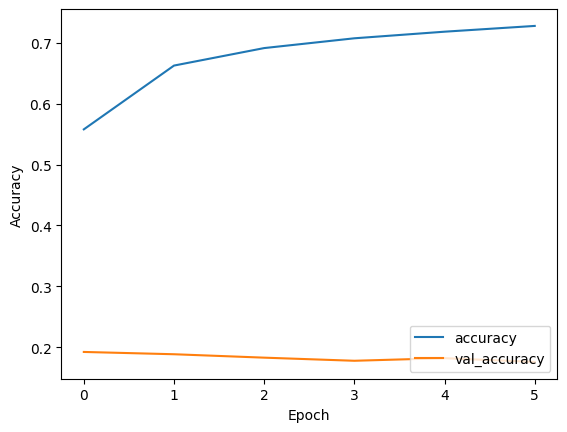

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Attention, Input, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model_with_attention(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # LSTM layer with return_sequences=True to keep the sequence dimension
    lstm_out = LSTM(128, return_sequences=True)(inputs)

    # Attention layer
    attention_out = Attention()([lstm_out, lstm_out])  # Self-attention

    # Flatten the attention output to pass into dense layers
    flattened_attention = Flatten()(attention_out)

    # Dense layers
    dense1 = Dense(64, activation='relu')(flattened_attention)
    outputs = Dense(num_classes, activation='softmax')(dense1)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Преобразуем данные в формат (samples, timesteps=1, features)
x_train_reshaped = np.expand_dims(x_train, axis=1)  # Теперь размерность (samples, 1, features)
x_val_reshaped = np.expand_dims(x_val, axis=1)

# Пример использования
input_shape = (x_train_reshaped.shape[1], x_train_reshaped.shape[2])
num_classes = 7  # Number of classes

model = create_model_with_attention(input_shape, num_classes)
model.summary()

# Определение callback-функций
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_attention.keras', monitor='val_accuracy', save_best_only=True)

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(x_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(x_val_reshaped, y_val),
                    callbacks=[early_stopping, model_checkpoint])

# График истории обучения
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [15]:
x_train.shape

(360528, 37)

1751/1751 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9583 - loss: 0.1507
Ошибка: 0.15295052528381348, точность: 0.9579317569732666
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


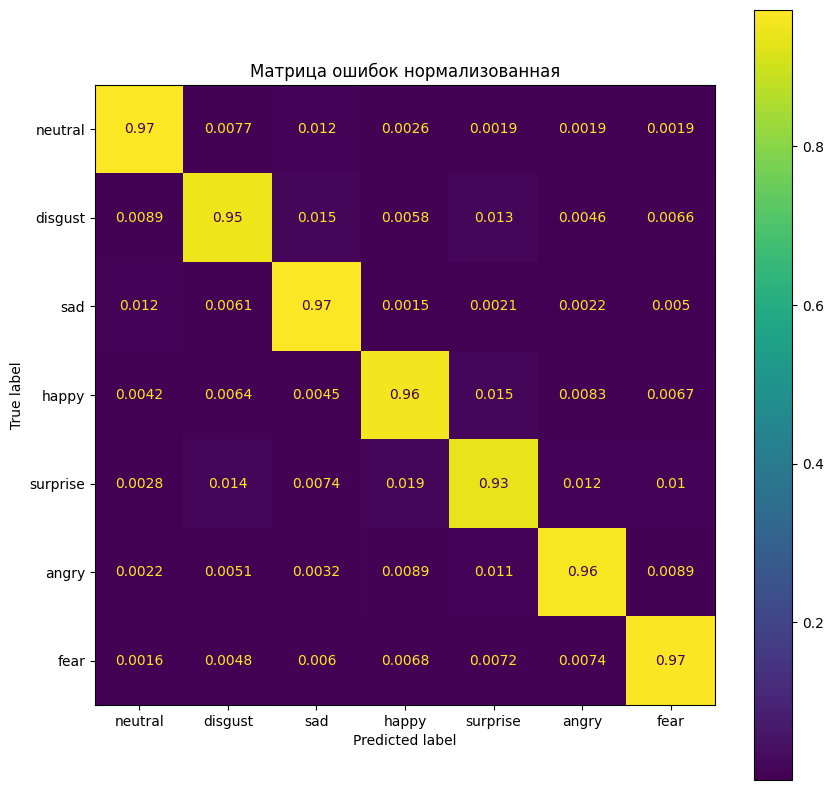

In [ ]:
eval_model(model, x_val, y_val)   # Оценка точности сети на проверочной выборке

In [ ]:
model.save('emotion_recognition_SAVEE.keras')

я вставил в бота и результат такой же она заучила и одно значение выдаёт